# Conversión de imagenes de paisajes en escala de grises a color usando TensorFlow

Carlos Iván Fonseca Mondragón - A01771689

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, MaxPool2D, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LeakyReLU
from tensorflow.image import ssim

In [2]:
# Verificar si TensorFlow detecta la GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPU detectada:", physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No se detectó GPU. Asegúrate de que TensorFlow esté configurado correctamente.")

GPU detectada: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Cargar conjuntos de imágenes (no es necesario aplicar transformaciones)
COLOR_PATH = 'color_processed/'
GRAY_PATH = 'gray_processed/'

def load_image_pair():
    gray_images = []
    color_images = []
    
    gray_dir = os.path.join(os.getcwd(), GRAY_PATH)
    color_dir = os.path.join(os.getcwd(), COLOR_PATH)

    for img in os.listdir(gray_dir): #Mismo número de imágenes en ambas carpetas
        image_gray = tf.io.read_file(os.path.join(gray_dir, img)) #Cargar cada imagen
        image_color = tf.io.read_file(os.path.join(color_dir, img))

        gray_img_tensor_int = tf.image.decode_jpeg(image_gray, channels=1)
        color_img_tensor_int = tf.image.decode_jpeg(image_color, channels=3)

        gray_img_float = tf.image.convert_image_dtype(gray_img_tensor_int, tf.float32, )
        color_img_float = tf.image.convert_image_dtype(color_img_tensor_int, tf.float32)

        gray_images.append(gray_img_float)
        color_images.append(color_img_float)

    return gray_images, color_images

In [4]:
X, y = load_image_pair()
# Separar train / test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Luego separar train de validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

2025-11-29 18:24:00.895917: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-11-29 18:24:00.895947: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-29 18:24:00.895953: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-29 18:24:00.895970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-29 18:24:00.895983: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
IMAGE_SIZE = (64, 64) # Tamaño de imagen
BATCH_SIZE = 32 
EPOCHS = 50
LATENT_DIM = 256

In [ ]:
# Creación del Modelo Autoencoder

inputs = Input(shape=(64, 64, 1))

# Encoder
x1 = Conv2D(32, (3,3), padding='same', activation=LeakyReLU(negative_slope=0.1))(inputs)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.1)(x1)

x2 = Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(x1)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.1)(x2)

x3 = Conv2D(128, (3,3), strides=2, padding='same', activation='relu')(x2)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.2)(x3)

x4 = Conv2D(256, (3,3), strides=2, padding='same', activation='relu')(x3)
x4 = BatchNormalization()(x4)
x4 = Dropout(0.2)(x4)

# Bottleneck
flat = Flatten()(x4)
latent = Dense(256, activation='relu')(flat)

In [8]:
# Decoder
x = Dense(8*8*256, activation='relu')(latent)
x = Reshape((8, 8, 256))(x)

x = Conv2DTranspose(256, (3,3), strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Concatenate()([x, x3])  # Skip connection

x = Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Concatenate()([x, x2])  # Skip connection

x = Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Concatenate()([x, x1])  # Skip connection

outputs = Conv2D(3, (3,3), padding='same', activation='sigmoid')(x)

In [ ]:
def lr_schedule(epoch): #Ajuste del learning rate conforme a las épocas de entrenamiento
    if epoch < 30:
        return 1e-4
    elif epoch < 60:
        return 5e-5
    else:
        return 1e-5

In [ ]:
# Definir la función de pérdida SSIM
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss=ssim_loss, metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  4,194,560 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16384)     │  4,210,688 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 256) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    590,080 │ reshape[0][0]     │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_transpose

 Total params: 9,942,627 (37.93 MB)

 Trainable params: 9,940,771 (37.92 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_autoencoder_model.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.LearningRateScheduler(lr_schedule),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                    patience=15, 
                                    restore_best_weights=True)   
]

In [ ]:
# Entrenamiento del modelo con datos de validación y callbacks
history = model.fit(np.array(X_train), np.array(y_train), 
          validation_data=(np.array(X_val), np.array(y_val)),
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          callbacks=callbacks
)

Epoch 1/50


2025-11-29 18:24:19.397749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


123/123 ━━━━━━━━━━━━━━━━━━━━ 35s 191ms/step - accuracy: 0.3479 - loss: 0.3784 - val_accuracy: 0.3302 - val_loss: 0.7140 - learning_rate: 1.0000e-04
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 35s 191ms/step - accuracy: 0.3479 - loss: 0.3784 - val_accuracy: 0.3302 - val_loss: 0.7140 - learning_rate: 1.0000e-04
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.3924 - loss: 0.1397 - val_accuracy: 0.4113 - val_loss: 0.5742 - learning_rate: 1.0000e-04
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.3924 - loss: 0.1397 - val_accuracy: 0.4113 - val_loss: 0.5742 - learning_rate: 1.0000e-04
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.4030 - loss: 0.1135 - val_accuracy: 0.4289 - val_loss: 0.4152 - learning_rate: 1.0000e-04
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.4030 - loss: 0.1135 - val_accuracy: 0.4289 - val_loss: 0.4152 - learning_rate: 1.0000e-04
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - 

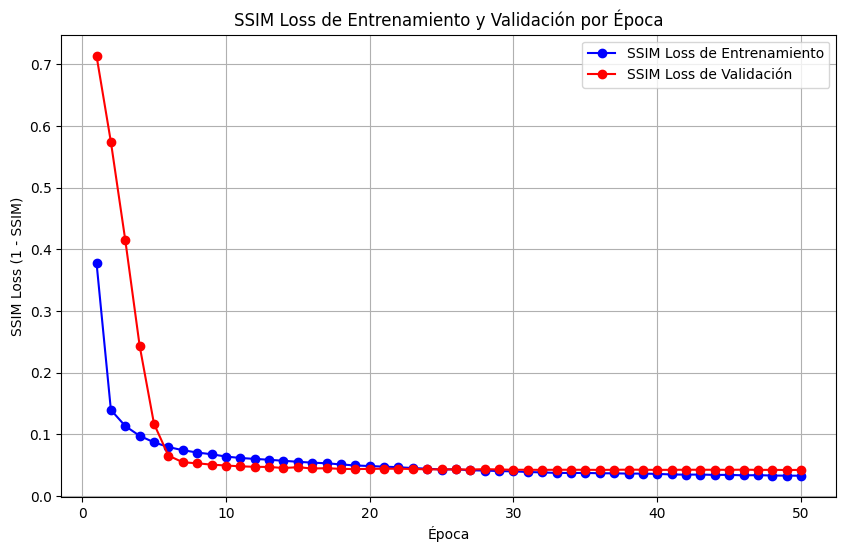

In [ ]:
# Obtener los valores de pérdida SSIM de entrenamiento y validación del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Graficar pérdidas SSIM
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='SSIM Loss de Entrenamiento')
plt.plot(epochs, val_loss, 'ro-', label='SSIM Loss de Validación')
plt.title('SSIM Loss de Entrenamiento y Validación por Época')
plt.xlabel('Época')
plt.ylabel('SSIM Loss (1 - SSIM)')
plt.legend()
plt.grid(True)
plt.show()
